# Simple Fortran kernel for Jupyter

## switching compilers
`%comipler: compiler-name .file-extention`

### default compiler is intel fortran 

In [1]:
use, intrinsic :: iso_fortran_env
print *, compiler_version()
end

 Intel(R) Fortran Intel(R) 64 Compiler for applications running on Intel(R) 64, 
 Version 19.0.0.117 Build 20180804


### gfortran 

In [2]:
%compiler: gfortran
use, intrinsic :: iso_fortran_env
print *, compiler_version()
end

 GCC version 7.3.0


In [15]:
%compiler: gfortran-8
use, intrinsic :: iso_fortran_env
print *, compiler_version()
end

 GCC version 8.1.0


### FIXED FORMAT 
default file extention is .f90 (free format)

In [4]:
%compiler: ifort .f
      PARAMETER(N = 100)
      OPEN(9, FILE = 'SINCOS.XY')
      PI = 4.0 * ATAN(1.0)
      DO 10 I = 0, N
        X = 2.0 * I * PI / N  
        WRITE(9, *) X, SIN(X), COS(X)
   10 CONTINUE
      STOP 'NORMAL TERMINATION'
      END

NORMAL TERMINATION


## compile C program 

In [5]:
%compiler: gcc .c
#include <stdio.h>
int main(void) {
    printf("Hello world\n");
    return 0;
}

Hello world


## Separate module compilation
`%module: object-file-name`

### The Sieve of Eratosthenes

In [6]:
%module: m
module m_eratos
    implicit none
contains
    integer function nprimes(n) 
        integer, intent(in) :: n
        logical, allocatable :: tab(:)
        integer :: i
        allocate(tab(2:n), source = .true.)
        do i = 2, n
            if (tab(i)) tab(i**2::i) = .false.
        end do
        nprimes = count(tab)
    end function nprimes    
end module m_eratos

[ifort kernel] module objects created successfully: m.o

## compiler options 
`fcflags: arg1 arg2 ...`
`ldflags: arg1 arg2 ...`

ifort *fcflags* source.f90 *ldflags*

to use module, put object-file-names to *fcflags*

In [7]:
%fcflags: m.o
program test
    use m_eratos
    implicit none
    integer :: i 
    do i = 1, 8
       write(*, *) i, 10**i, nprimes(10**i), nint(10**i / log(10.0**i))
       write(9, *) i, 10**i, nprimes(10**i), nint(10**i / log(10.0**i))
    end do
end program test

           1          10           4           4
           2         100          25          22
           3        1000         168         145
           4       10000        1229        1086
           5      100000        9592        8686
           6     1000000       78498       72382
           7    10000000      664579      620421
           8   100000000     5761455     5428681


# Matplotlib Ready
`%fig: args`

```python
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure( args )
```

> ...

> ( user inputs are executed by Python's exec command )

> ... 

```python
plt.show()
```

### note
I don't know why, but `plt.figure()` doesn't work properlly with `exec/eval` commands. So it is hard coded in the kernel.    

## number of primes $\pi(n)$
$$
\large\pi(n)\simeq{n \over \log(n)}
$$

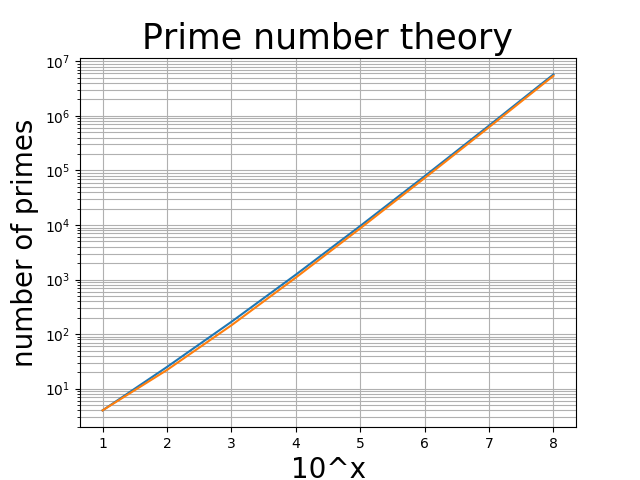

In [8]:
%fig:
x, y1, y2, y3 = np.loadtxt('fort.9', unpack = True)
plt.yscale('log')
plt.grid(which='both')
plt.plot(x, y2)
plt.plot(x, y3)
plt.title('Prime number theory', fontsize = 25)
plt.xlabel('10^x', fontsize = 20)
plt.ylabel('number of primes', fontsize = 20)

### sin cos curves

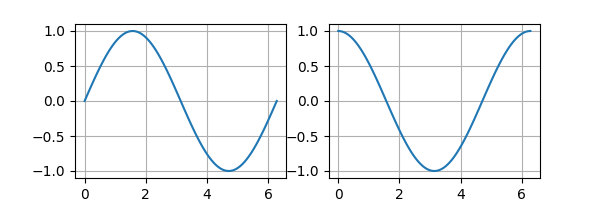

In [9]:
%fig:figsize=(6, 2)
x, y1, y2 = np.loadtxt('SINCOS.XY', unpack = True)
plt.subplot(1, 2, 1)
plt.grid(which='both')
plt.plot(x, y1)
plt.subplot(1, 2, 2)
plt.grid(which='both')
plt.plot(x, y2)

## PIL example

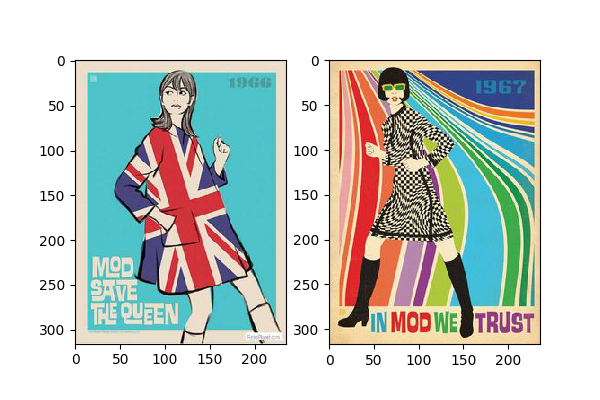

In [10]:
%fig: figsize=(6, 4)
from PIL import Image
im1 = Image.open('mod1.jpg')
im2 = Image.open('mod2.jpg')
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)

# Display Images   (MIME: image/xxx)
`%image: fn1 fn2 ...`

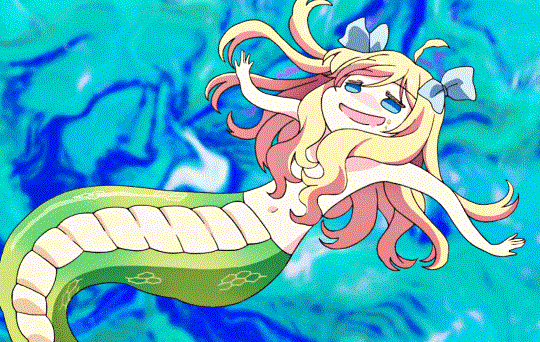

In [11]:
%image: hebi.gif

## BMP example

In [17]:
%module: BMP
    module m_bmp
      use, intrinsic :: iso_fortran_env
      implicit none
      type :: t_bmp_file_header
        sequence  
        integer(int16) :: bfType = transfer('BM', 0_int16) ! BitMap
        integer(int32) :: bfSize          ! file size in bytes
        integer(int16) :: bfReserved1 = 0 ! always 0
        integer(int16) :: bfReserved2 = 0 ! always 0
        integer(int32) :: bfOffBits
      end type t_bmp_file_header
      !
      type :: t_bmp_info_header
        sequence
        integer(int32) :: biSize          = Z'28' ! size of bmp_info_header ; 40bytes 
        integer(int32) :: biWidth
        integer(int32) :: biHeight
        integer(int16) :: biPlanes        = 1 ! always 1
        integer(int16) :: biBitCount
        integer(int32) :: biCompression   = 0 ! 0:nocompression, 1:8bitRLE, 2:4bitRLE, 3:bitfield
        integer(int32) :: biSizeImage
        integer(int32) :: biXPelsPerMeter = 3780 ! 96dpi
        integer(int32) :: biYPelsPerMeter = 3780 ! 96dpi 
        integer(int32) :: biClrUsed       = 0
        integer(int32) :: biClrImportant  = 0 
      end type t_bmp_info_header
      !
      type :: t_rgb
        sequence
        integer(int8) :: ib, ig, ir
      end type t_rgb  
    contains   
      subroutine wr(bmp, fn)
        type(t_rgb), intent(in) :: bmp(:, :)
        character(len = *), intent(in) :: fn
        type(t_bmp_file_header) :: bmp_file_header
        type(t_bmp_info_header) :: bmp_info_header
        integer :: i, nx, ny
        nx = size(bmp, 1)
        ny = size(bmp, 2)
        bmp_file_header%bfSize      = 14 + 40 + 0 + (3 * nx + mod(ny, 4)) * ny
        bmp_file_header%bfOffBits   = 14 + 40
        bmp_info_header%biWidth     = nx
        bmp_info_header%biHeight    = ny
        bmp_info_header%biBitCount  = 24 
        bmp_info_header%biSizeImage = (3 * nx + mod(ny, 4)) * ny
        open(9, file = fn // '.bmp', access = 'stream', status = 'unknown')
        write(9) bmp_file_header
        write(9) bmp_info_header
        write(9) (bmp(:, i), repeat(achar(0), mod(nx, 4)), i = 1, ny)
        close(9)
      end subroutine wr  
    end module m_bmp

/home/O/jupyter-ifort-kernel/jupyter-ifort-kernel/example/tmp/tmpqza5z4uq.f90(4): warning #6379: The structure contains one or more misaligned fields.   [T_BMP_FILE_HEADER]
      type :: t_bmp_file_header
--------------^
[ifort kernel] module objects created successfully: BMP.o

In [20]:
%fcflags: BMP.o
    module m_mandel
      use, intrinsic :: iso_fortran_env
      implicit none
      integer, parameter :: kd = real64
      integer, parameter :: maxiter = 255
    contains
      pure elemental integer function mandel(c)
        complex(kd), intent(in) :: c
        complex(kd) :: z
        z = c
        do mandel = maxiter, 1, -1
          if (abs(z) > 2.0_kd) exit
          z = z**2 + c
        end do 
      end function mandel
    end module m_mandel


    program mandelbrot
      use m_bmp 
      use m_mandel
      implicit none
      complex(kd), allocatable :: c(:, :)
      type(t_rgb), allocatable :: bmp(:, :)
      integer  :: ix, iy, nx, ny
      real(kd) :: xmin, ymin, xmax, ymax
      xmin = 0.15_kd
      xmax = 0.25_kd
      ymin = 0.50_kd
      ymax = 0.60_kd
      nx = 640
      ny = 640
      allocate( c(nx, ny) )
      forall (ix = 1:nx, iy = 1:ny) c(ix, iy) = cmplx(pos(ix, nx, xmin, xmax), pos(iy, ny, ymin, ymax)) 
      bmp = to_rgb( mandel(c) ) 
      call wr(bmp, 'mandel')
      stop 'normal end'
    contains
      pure real(kd) function pos(i, n, rmin, rmax) 
        integer , intent(in) :: i, n
        real(kd), intent(in) :: rmin, rmax
        pos = (rmax - rmin) / (n - 1) * i + rmin
      end function pos
      !
      pure elemental type(t_rgb) function to_rgb(k)
        integer, intent(in) :: k
        to_rgb = t_rgb(10 * k,  k, 5 * k)
      end function to_rgb
    end program mandelbrot

normal end


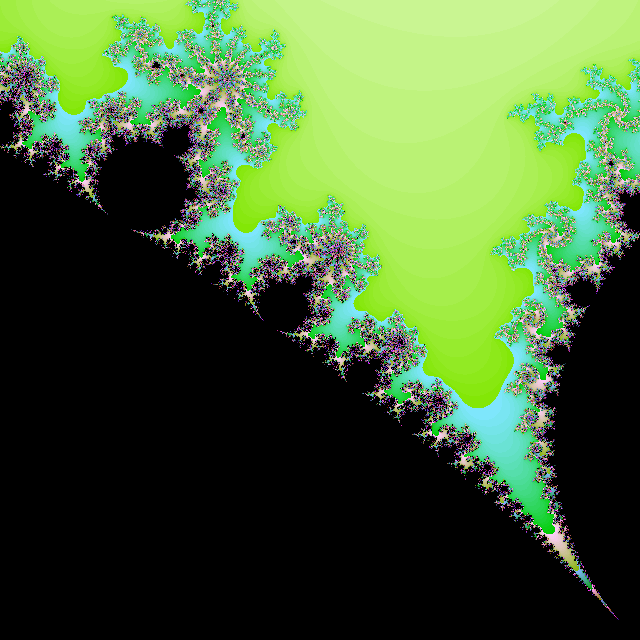

In [21]:
%image: mandel.bmp